In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../')
import utilities


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

/tmp/ipykernel_55460/2928747477.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [4]:
# ticker = "MSFT"
# df = utilities.load_stock(ticker)
ticker = 'SPY'
df = utilities.load_index(ticker)

In [5]:
# Add Indicators

df = utilities.RSI(df, 14)
df = utilities.RSI(df, 28)
df = utilities.RSI(df, 56)
df = utilities.RSI(df, 100)
df = utilities.RSI(df, 200)

df = utilities.MACD(df)

df = utilities.EMA(df, 10)
df = utilities.EMA(df, 50)
df = utilities.EMA(df, 200)

df = utilities.market_hours_only(df)
df = utilities.time_to_numeric(df)

In [6]:
df.head()

,timestamp,open,high,low,close,volume,ticker,date,time,rsi14,...,rsi56,rsi100,rsi200,macd,signal,histogram,ema10,ema50,ema200,minute
56,2005-01-03 09:30:00,121.56,121.57,121.49,121.50,349600,SPY,2005-01-03,09:30:00,40.6250,...,47.3684,NaN,NaN,-0.0158,-0.0156,-0.0002,121.5111,121.5393,NaN,570
57,2005-01-03 09:31:00,121.50,121.56,121.49,121.56,205300,SPY,2005-01-03,09:31:00,48.6486,...,51.2195,NaN,NaN,-0.0110,-0.0147,0.0037,121.5200,121.5402,NaN,571
58,2005-01-03 09:32:00,121.56,121.58,121.52,121.53,159600,SPY,2005-01-03,09:32:00,45.0000,...,48.1928,NaN,NaN,-0.0094,-0.0136,0.0042,121.5218,121.5397,NaN,572
59,2005-01-03 09:33:00,121.53,121.60,121.52,121.57,165500,SPY,2005-01-03,09:33:00,50.0000,...,51.1628,NaN,NaN,-0.0049,-0.0119,0.0069,121.5306,121.5410,NaN,573
60,2005-01-03 09:34:00,121.59,121.66,121.57,121.63,371700,SPY,2005-01-03,09:34:00,59.5745,...,54.3478,NaN,NaN,0.0034,-0.0088,0.0122,121.5486,121.5449,NaN,574


In [7]:
# map the "minute" column, from 570 to 930, to 0 to 1

df['minute'] = df['minute'].apply(lambda x: (x - 570) / (960 - 570))

In [8]:
# Drop non-numeric columns
df = df.drop(columns=['timestamp', 'ticker', 'date', 'time'])

In [9]:
df.head()

,open,high,low,close,volume,rsi14,rsi28,rsi56,rsi100,rsi200,macd,signal,histogram,ema10,ema50,ema200,minute
56,121.56,121.57,121.49,121.50,349600,40.6250,41.6667,47.3684,NaN,NaN,-0.0158,-0.0156,-0.0002,121.5111,121.5393,NaN,0.000000
57,121.50,121.56,121.49,121.56,205300,48.6486,49.0566,51.2195,NaN,NaN,-0.0110,-0.0147,0.0037,121.5200,121.5402,NaN,0.002564
58,121.56,121.58,121.52,121.53,159600,45.0000,48.1481,48.1928,NaN,NaN,-0.0094,-0.0136,0.0042,121.5218,121.5397,NaN,0.005128
59,121.53,121.60,121.52,121.57,165500,50.0000,51.7241,51.1628,NaN,NaN,-0.0049,-0.0119,0.0069,121.5306,121.5410,NaN,0.007692
60,121.59,121.66,121.57,121.63,371700,59.5745,57.1429,54.3478,NaN,NaN,0.0034,-0.0088,0.0122,121.5486,121.5449,NaN,0.010256


In [10]:
# normalize all other columns
for col in df.columns:
    if col != 'enter':
        df[col] = (df[col] - df[col].min()) / (df[col].max() - df[col].min())

In [11]:
# Create a column called "value", which repserents how many of the next closes after this one are higher than the current close.
# The window is 390*5, to mean the next 5 days, so the last 100 values will be NaN.


window = 390 * 5 - 1 # Adjusted the window size

# Create a column called "value"
df['value'] = df['close'].rolling(window=window).apply(lambda x: np.mean(x > x.iloc[-1])) 
df['value'] = df['value'].shift(-window)

In [12]:
df.head()

,open,high,low,close,volume,rsi14,rsi28,rsi56,rsi100,rsi200,macd,signal,histogram,ema10,ema50,ema200,minute,value
56,0.128348,0.128166,0.128239,0.128206,0.011219,0.406250,0.405412,0.483505,NaN,NaN,0.410056,0.430532,0.468849,0.128032,0.127977,NaN,0.000000,0.903027
57,0.128206,0.128143,0.128239,0.128348,0.006587,0.486486,0.484329,0.536224,NaN,NaN,0.410908,0.430718,0.470988,0.128053,0.127980,NaN,0.002564,0.906619
58,0.128348,0.128190,0.128310,0.128277,0.005120,0.450000,0.474627,0.494791,NaN,NaN,0.411192,0.430946,0.471262,0.128057,0.127978,NaN,0.005128,0.902001
59,0.128277,0.128237,0.128310,0.128371,0.005309,0.500000,0.512816,0.535447,NaN,NaN,0.411990,0.431297,0.472743,0.128078,0.127981,NaN,0.007692,0.911750
60,0.128419,0.128378,0.128428,0.128513,0.011928,0.595745,0.570684,0.579048,NaN,NaN,0.413463,0.431939,0.475650,0.128120,0.127991,NaN,0.010256,0.923551


In [13]:
df.describe()

,open,high,low,close,volume,rsi14,rsi28,rsi56,rsi100,rsi200,macd,signal,histogram,ema10,ema50,ema200,minute,value
count,1.873694e+06,1.873694e+06,1.873694e+06,1.873694e+06,1.873694e+06,1.873694e+06,1.873694e+06,1.873694e+06,1.873650e+06,1.873550e+06,1.873694e+06,1.873694e+06,1.873694e+06,1.873694e+06,1.873694e+06,1.873551e+06,1.873694e+06,1.871745e+06
mean,3.606592e-01,3.605643e-01,3.605945e-01,3.606593e-01,9.119904e-03,5.053783e-01,5.001069e-01,5.262207e-01,5.129882e-01,3.783051e-01,4.129931e-01,4.339243e-01,4.689376e-01,3.606761e-01,3.608362e-01,3.612988e-01,4.994650e-01,4.353984e-01
std,2.579567e-01,2.579818e-01,2.579134e-01,2.579568e-01,1.271474e-02,1.612635e-01,1.219542e-01,1.113354e-01,1.069713e-01,8.145672e-02,2.018796e-02,2.201346e-02,1.883264e-02,2.581981e-01,2.585099e-01,2.594339e-01,2.892940e-01,3.547887e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.487216e-01,1.486039e-01,1.487044e-01,1.487408e-01,2.516572e-03,3.896100e-01,4.139454e-01,4.490194e-01,4.392334e-01,3.226662e-01,4.065256e-01,4.268477e-01,4.624328e-01,1.485392e-01,1.484234e-01,1.480955e-01,2.487179e-01,8.209338e-02
50%,2.935782e-01,2.934597e-01,2.935185e-01,2.935920e-01,4.995427e-03,5.053760e-01,5.008949e-01,5.267275e-01,5.132960e-01,3.778111e-01,4.134450e-01,4.344227e-01,4.688494e-01,2.935333e-01,2.935876e-01,2.937386e-01,5.000000e-01,3.755772e-01
75%,5.144757e-01,5.143952e-01,5.143942e-01,5.144757e-01,1.053554e-02,6.214437e-01,5.864110e-01,6.038593e-01,5.867949e-01,4.332298e-01,4.199386e-01,4.415423e-01,4.753757e-01,5.146251e-01,5.149848e-01,5.160930e-01,7.487179e-01,7.865572e-01
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,9.994869e-01


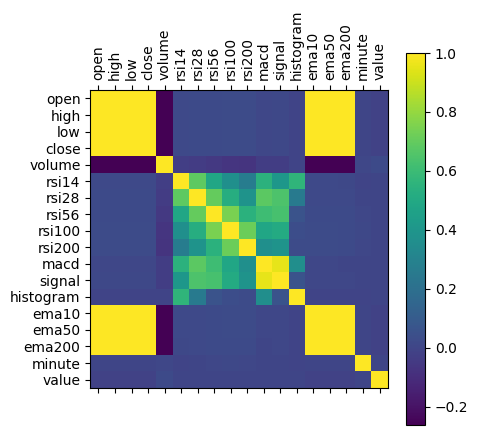

In [15]:
# show the correlation matrix
correlation_matrix = df.corr()
plt.matshow(correlation_matrix)

plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=90)
plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)
plt.colorbar()
plt.gcf().set_size_inches(10, 10)

plt.show()

In [ ]:
df.to_csv('valued_SPY.csv', index=False)